# ML Final Project JN - Holistic Regresssion

In [1]:
using ScikitLearn, JuMP, Gurobi, Optim, Distributions, Ipopt, StatsBase,
CSV, LinearAlgebra,Rmath, Arpack, Random, DataFrames, StatsPlots

In [2]:
@sk_import preprocessing: normalize
@sk_import preprocessing: StandardScaler
@sk_import preprocessing: MinMaxScaler
@sk_import datasets: make_regression

PyObject <function make_regression at 0x1474c3510>

In [3]:
#PARKINSONS FROM HW3
park = CSV.read("/Users/johnnicholas/desktop/ML/Hw/Hw3/parkinsons_updrs1.csv");
X_park = park[:, 1:16];
y_park = park[:, 17];
#ADMIT FROM OLD
admit = CSV.read("/Users/johnnicholas/desktop/ML/project/code/admit.csv")
X_admit = admit[:,3:9];
y_admit = admit[:,10];
#BOSTON DATASET
boston = CSV.read("/Users/johnnicholas/desktop/ML/project/code/Boston.csv", header=true)[:,2:15]
X_bos = boston[:,1:13];
y_bos = boston[:,14];
gables = CSV.read("/Users/johnnicholas/desktop/ML/project/code/CoralGablesHouses.csv", header=true);
mid = hcat(gables[:,1],gables[:,7:10]);
X_gables = hcat(mid, gables[:,3:6]);
y_gables = gables[:,2];

In [4]:
function MeanImpute(X)
    X_mean_impute = deepcopy(X)
    for d in 1:size(X, 2)
      idx_missing = ismissing.(X[:,d])
      X_mean_impute[idx_missing, d] .= mean(X[.!idx_missing, d])  
    end    
return X_mean_impute
end

MeanImpute (generic function with 1 method)

In [19]:
#now this function works and returns integers to index by later
function HighCorrelation(X,HC)
   X = convert(Matrix, X)
corr = cor(X)
    z = ones(1,2)
for i = 1:size(corr)[1]
           for j = i:size(corr)[1]
    if abs(corr[i,j]) >= HC && i!=j 
            q=[i,j]'
            z=vcat(z,q)    
            end
        end
    end  
  return round.(Int,z[2:size(z)[1],1:2])
end

HighCorrelation (generic function with 1 method)

In [20]:
function betaUB(X,Y,UB,i)
    p=size(X)[2]
    LB=Model(solver=GurobiSolver(OutputFlag=0))
    @variable(LB,β[1:p])
    @constraint(LB,norm(Y-X*β)<=UB)
    @objective(LB,Max,β[i])
    solve(LB)
    β_opti=getvalue(β)
    return β_opti[i]
end

betaUB (generic function with 1 method)

In [21]:
function betaLB(X,Y,UB,i)
    p=size(X)[2]
    LB=Model(solver=GurobiSolver(OutputFlag=0))
    @variable(LB,β[1:p])
    @constraint(LB,norm(Y-X*β)<=UB)
    @objective(LB,Min,β[i])
    solve(LB)
    β_opti=getvalue(β)
    return β_opti[i]
end

betaLB (generic function with 1 method)

In [22]:
function findobjUB(X,Y)
p=size(X)[2]
    function naiveobjective(β)
        obj=norm(Y-X*β,2)
        return obj
    end
initial_x=Array{Float64}(undef, p)
initial_x.=0
res=Optim.optimize(naiveobjective, initial_x, NelderMead(),Optim.Options(time_limit = 10.0))
obj_UB=Optim.minimum(res)
β_UB=Optim.minimizer(res)
return obj_UB, β_UB
end

findobjUB (generic function with 1 method)

In [23]:
#CALLS findobjUB, betaUB, and betaLB
#Looks like this is for finding a big M to minimize computational time... cool.
#It is now working...
function findM(X,Y)
    Y= convert(Array, Y)
    X = convert(Matrix, X)
    obj_UB, β_UB=findobjUB(X,Y)
    println("Upper bound of Objective is $obj_UB")
    p=size(X)[2]
    UBArray=Array{Float64}(undef, p)
    LBArray=Array{Float64}(undef, p)
    for i=1:p
        UBArray[i]=betaUB(X,Y,obj_UB,i)
        LBArray[i]=betaLB(X,Y,obj_UB,i)
    end
    return max(maximum(UBArray),minimum(LBArray))
end

findM (generic function with 1 method)

In [24]:
#for getting non-linear transformations of X. 
#Fixed Log issue
function NLTransform(X)
    X = convert(Matrix, X)
    logX=log.(X)
    sqrtX=sqrt.(X)
    sqX=X.*X
    oldColumn=size(X)[2]
    X=hcat(X,logX,sqrtX,sqX)
    NLArray=Matrix{Int64}(I,oldColumn,4)
    for i=1:oldColumn
            NLArray[i,1]=i
            NLArray[i,2]=i+oldColumn
            NLArray[i,3]=i+oldColumn*2
            NLArray[i,4]=i+oldColumn*3
    end
    X = replace!(X, -Inf=>0)
    X = replace!(X, Inf=>0)
    return NLArray, X
end

NLTransform (generic function with 1 method)

In [163]:
#Will get to this soon this winter. Will speed up calculation of multicollinear pairs.
function GlobalMCor(x,delta)    
    X = convert(Matrix, x)
    cols = eigvals(X'*X).<= 0.01
    v = eigvecs(X'*X)[:,cols]
    p = size(v)[1] 
    m = size(v)[2] 
    partd = Model(solver=GurobiSolver(TimeLimit=45, OutputFlag=0))
    # Optimization variables
    @variable(partd, z[j=1:p], Bin)
    @variable(partd, d[i=1:m], Bin)
    @variable(partd, y[h=1:2], Bin)
    @variable(partd, a[j=1:p])
    @variable(partd, t[i=1:m])
    @variable(partd, b)
    # Objective
    @objective(partd, Min, sum(z))
    # Constraints
    @constraint(partd, [j=1:p], 500*z[j] >= a[j])
    @constraint(partd, [j=1:p], -500*z[j] <= a[j])
    @constraint(partd, sum(t[i].*v[:,i] for i in 1:m, dims=2) .== a)
    @constraint(partd, b == sum(t))
    @constraint(partd, b <= -delta + (500)*(1-y[1]))
    @constraint(partd, b >= delta + (-500)*(1-y[2]))
    @constraint(partd, y[1] + y[2] == 1)
    solve(partd)
    status = solve(partd)
S=[]    
while status != "INFEASIBLE"
supp_a = findall(x -> x >= 0.001, getvalue(z))
        
  if iszero(supp_a) == false
    push!(S, supp_a)
    @constraint(partd, sum(z[i] for i in supp_a) <= length(supp_a)-1)
    solve(partd)
    status = solve(partd) 
  else 
    break
  end      
end
    if size(S,1)<=1
        S=zeros(1,(size(X,2)))
    else
    end
S = filter(x -> size(x,1) >=2 ,S)   
 return S   
end

GlobalMCor (generic function with 1 method)

In [413]:
function Normalize(X, Y)
scaler =  MinMaxScaler()
        X = ScikitLearn.fit_transform!(scaler,X)
        Y = ScikitLearn.fit_transform!(scaler,convert(Matrix,hcat(Y,ones(size(Y,1),1))))[:,1]
    return X,Y
end

Normalize (generic function with 1 method)

In [489]:
function OptSplit(vector,trainp)
model = Model(solver=GurobiSolver(TimeLimit=120, OutputFlag=0))
    full_size = size(vector,1)
    train_size=round(Int,size(vector,1)*trainp)
    one1 = vector
    rho=1
    # Optimization variables
    h = size(one1,1)
    @variable(model, x[i=1:h,p=1:2], Bin)
    @variable(model, d>=0)
    
    # Objective
    @objective(model, Min, d)
    
    
    # Constraints
    #u1 - u2 + o1 - o2
    @constraint(model, d >= (1/10)*sum(one1[i]*x[i,1] for i in 1:h) - (1/10)*sum(one1[i]*x[i,2] for i in 1:h)
                       +rho*(1/10)*sum((one1[i]^2)*x[i,1] for i in 1:h) - rho*(1/10)*sum((one1[i]^2)*x[i,2] for i in 1:h))

    #u1 - u2 - o1 + o2
    @constraint(model, d >= (1/10)*sum(one1[i]*x[i,1] for i in 1:h) - (1/10)*sum(one1[i]*x[i,2] for i in 1:h)
                        -rho*(1/10)*sum((one1[i]^2)*x[i,1] for i in 1:h) + rho*(1/10)*sum((one1[i]^2)*x[i,2] for i in 1:h))




    #-u1 + u2 + o1 - o2
     @constraint(model, d >= -(1/10)*sum(one1[i]*x[i,1] for i in 1:h)+(1/10)*sum(one1[i]*x[i,2] for i in 1:h)
                          +rho*(1/10)*sum((one1[i]^2)*x[i,1] for i in 1:h) - rho*(1/10)*sum((one1[i]^2)*x[i,2] for i in 1:h)) 


    #-u1 + u2 - o1 + o2
    @constraint(model, d >= -(1/10)*sum(one1[i]*x[i,1] for i in 1:h)+(1/10)*sum(one1[i]*x[i,2] for i in 1:h)
                        -rho*(1/10)*sum((one1[i]^2)*x[i,1] for i in 1:h) + rho*(1/10)*sum((one1[i]^2)*x[i,2] for i in 1:h))
    
@constraint(model, sum(x[i,1] for i in 1:h) == train_size)
@constraint(model, sum(x[i,2] for i in 1:h) == abs(train_size-full_size))
@constraint(model, [i=1:h], sum(x[i,p] for p in 1:2) == 1)   
     solve(model)

  return getvalue(d), getvalue(x)
end

OptSplit (generic function with 1 method)

In [490]:
function OptSplitWrapper(X,vector, trainp)
    full_size = size(vector,1)
    y = OptSplit(vector,trainp)
    first_grp  = filter( y -> abs(y)>=0.000000001, (round.(Int,y[2][1:full_size]).*vector));
    second_grp = filter( y -> abs(y)>=0.000000001, (round.(Int,y[2][full_size+1:2*full_size]).*vector));

    #Recover X_train from OptSplit y_train
    admit_c = convert(DataFrame,hcat(convert(Matrix,X),convert(Vector,vector)))
    X_c = convert(DataFrame,copy(X))
    X_group1 = ones(1,size(X,2))
    for i in 1:size(first_grp,1)
        j = findall(x-> x==first_grp[i],admit_c[:,size(admit_c,2)])[1]
        X_group1 = vcat(X_group1 , convert(Vector,X_c[j,:])')
        deleterows!(admit_c, j)
        deleterows!(X_c, j)
    end
    X_train = X_group1[2:size(X_group1,1),:]
    #END
    
    #Recover X_test from OptSplit y_train
    X_group2 = ones(1,size(X,2))
    for i in 1:size(second_grp,1)
        j = findall(x-> x==second_grp[i],admit_c[:,size(admit_c,2)])[1]
        X_group2 = vcat(X_group2 , convert(Vector,X_c[j,:])')
        deleterows!(admit_c, j)
        deleterows!(X_c, j)
    end
    X_test = X_group2[2:size(X_group2,1),:]
    #END
    
    return first_grp, second_grp, X_train, X_test
end

OptSplitWrapper (generic function with 2 methods)

# Now comes regression methods

In [491]:

function OptimRegression(X,Y,X_valid,Y_valid,X_test,Y_test,invX,vari,HCArray,HC,M,NLArray,sign,MCArray,NLtrue=false, Signtrue=false,returnbeta=false, MCtrue=false)
    function RegressionWrapper(x)
        obj, β=SystematicRegression(X,Y,invX,vari,x[1],x[2],HCArray,HC,M,NLArray,sign,MCArray,NLtrue,Signtrue,true, MCtrue)
        β[findall(abs.(β).<1e-5)].=0
        obj_valid=norm(Y_valid-X_valid*β,2)
        return obj_valid
    end
    initial_x=[0.1,5]
    println("Optimizer Starting")
    res=Optim.optimize(RegressionWrapper, initial_x, NelderMead(),Optim.Options(f_calls_limit=20))
    opti_HP=Optim.minimizer(res)
    obj_valid=Optim.minimum(res)
    obj_opti,β_opti=SystematicRegression(X,Y,invX,vari,opti_HP[1],opti_HP[2],HCArray,HC,M,NLArray,sign,MCArray,NLtrue,Signtrue,true,MCtrue)
    β_opti[findall(abs.(β_opti).<1e-5)].=0
    obj_test=norm(Y_test-X_test*β_opti,2)
    return β_opti,obj_valid,obj_test,opti_HP[1],opti_HP[2]
end

OptimRegression (generic function with 5 methods)

In [492]:

function SystematicRegression(X,Y,invX,vari,Γ,k,HCArray,HC,M,NLArray,sign,MCArray,NLtrue=false, Signtrue=false,returnbeta=false,MCtrue=false)
# If we want to also test significance, write Signtrue=true
# sign is the t-value threshold you want to test
# if you want beta values to be returned, take returnbeta as true
if Γ<=0
    Γ=0
end
if Γ>=1
    Γ=1
end
if k>=size(X)[2]-size(NLArray)[1]*3
    k=size(X)[2]-size(NLArray)[1]*3
end
if k<=1
    k=1
end
M2=100000
model=Model(solver=GurobiSolver(OutputFlag=0,NumericFocus=2))
if size(X)[1] !=size(Y)[1]
    throw(ArgumentError("check sizes of array X and Y"))
end
n=size(X)[1]
p=size(X)[2]
@variable(model,z[1:p],Bin)
@variable(model,β[1:p])
@variable(model,l[1:p])
@constraint(model,[i=1:p], l[i]>=β[i])
@constraint(model,[i=1:p], l[i]>=-β[i])
@constraint(model,[i=1:p], M*z[i]>=β[i])
@constraint(model,[i=1:p], M*z[i]>=-β[i])
@constraint(model,sum(z[i] for i=1:p)<=k) #Sparsity
if size(HCArray)[1]>0
    for i=1:size(HCArray)[1]
        @constraint(model,sum(z[HCArray[i,j]] for j=1:size(HCArray)[2])<=1) #pairwise collinearity
    end
end
if NLtrue
    for i=1:size(NLArray)[1]
        @constraint(model,sum(z[NLArray[i,j]] for j=1:size(NLArray)[2])<=1) # Nonlinear transformation
    end
end
if Signtrue
    if NLtrue
        @variable(model,b[1:p],Bin)
        for i=1:p
            k=mod(i,p/4)
            if k==0
                k=p/4
            end
            k=convert(Int64,k)
            c=(1)./sqrt(vari*invX[k,k])
            @constraint(model,β[i]*c[1]+M2*c[1]*b[i]>=(quantile(TDist(n-p),1-sign))*z[i]) #significance
            @constraint(model,β[i]*c[1]+M2*c[1]*b[i]<=M2*c[1]-(quantile(TDist(n-p),1-sign))*z[i])  #significance
        end
    else
        @variable(model,b[1:p],Bin)
        for i=1:p
            c=(1)./sqrt(vari*invX[i,i])
            @constraint(model,β[i]*c[1]+M2*c[1]*b[i]>=(quantile.(TDist(n-p),1-sign*0.5))*z[i]) #significance
            @constraint(model,β[i]*c[1]+M2*c[1]*b[i]<=M2*c[1]-(quantile.(TDist(n-p),1-sign*0.5))*z[i]) #significance
        end
    end
end
if MCtrue
      if size(MCArray,1)>0                     
       for i in 1:size(MCArray,1)
        @constraint(model,sum(z[j] for j in size(MCArray[i],1)) <= length(size(MCArray[i],1)))
       end
      end
end
@objective(model, Min, sum((Y[i]-(X*β)[i])*(Y[i]-(X*β)[i]) for i=1:n)/2+sum(l[i] for i=1:p)Γ)
solve(model)
β_opti=getvalue(β)
objective=getobjectivevalue(model)
if returnbeta
    return objective, β_opti
else
    return objective
end
end

SystematicRegression (generic function with 5 methods)

In [493]:
function SRegression2(X,Y,HC,NLtrue,sign,Signtrue,Normtrue,MCtrue,Imputetrue)
    #This gets done in the outerfunction
    #X=convert(Matrix,X)
    #Y=convert(Array,y)
    
      #Normalization/Imputation
    if Normtrue 
       nrm = Normalize(X,Y)
        X = nrm[1]
        Y = nrm[2]
    end
     println("Normalization complete")
     
    if Imputetrue
    X = MeanImpute(X)
    end
   
    
    #There is no random/optimal splitting done in here, just splitting up what's passed in.
    train=round(Int,size(X)[1]*0.6)
    test=round(Int,size(X)[1]*0.8)
     
  
    X_train_1=X[1:train,:]
    Y_train_1=Y[1:train]
    
    M=findM(X_train_1,Y_train_1)
    println("M found: $M")
    invX=inv(X_train_1'X_train_1)
    P=X_train_1*(invX)X_train_1'
    n=size(X_train_1)[1]
    p=size(X_train_1)[2]
    RSS=Y_train_1'*(I(n)-P)Y_train_1
    vari=RSS/(n-p)
    println("Significance Calculated")
    if NLtrue && !Normtrue
        println("ERROR if NLTRUE, THEN ALSO MAKE NORM TRUE")
    elseif NLtrue
        NLArray, X=NLTransform(X)
    else
        NLArray = zeros(0,0)
    end
    X_train=X[1:train,:]
    Y_train=Y[1:train]
    X_valid=X[train+1:test,:]
    Y_valid=Y[train+1:test]
    X_test=X[test:end,:]
    Y_test=Y[test:end]
    println("Split completed")
    HCArray=HighCorrelation(X_train,HC)
    println("HCArray found")
    MCArray = GlobalMCor(X_train,0.015)
    MCArraySize=size(MCArray,1)
    println("MCArray found, Size: $MCArraySize")
    println(MCArray)
    β, obj_valid,obj_test, Γ, k=OptimRegression(X_train,Y_train,X_valid,Y_valid,X_test,Y_test,invX,vari,HCArray,HC,M,NLArray,sign,MCArray,NLtrue,Signtrue,false,MCtrue)
    return β, obj_valid,obj_test, Γ, k
end

SRegression2 (generic function with 2 methods)

# Now wrote Holistic Regression Wrapper that just takes data & T/F

In [494]:
function HolisticRegression(X,Y,HC=0.99,NLtrue=false,sign=0.95,Signtrue=false,Normtrue=false,
                             MCtrue=false,OptSplit=false,Imputetrue=false,trainp=0.8)
    
    #Conversion to array if not an array
    if typeof(X) != Array
      X=convert(Matrix{Float64},X)
    end
    if typeof(X) != Array
      Y=convert(Vector{Float64},Y)
    end
    #End
    
    #Split into train and test
    if OptSplit == true
        groups = OptSplitWrapper(X,Y, trainp)
        Y_train = groups[1] 
        Y_test = groups[2]
        X_train = groups[3]
        X_test = groups[4]
    println("Optimal data split calculated")
          
    else
      Random.seed!(4567)
      index = Distributions.sample(1:size(X,1),size(X,1),replace=false);
      train=round(Int,size(X,1)*trainp)
      X_train = X[1:train,:]
      X_test =  X[train+1:size(X,1),:]
      Y_train = Y[1:train,:]
      Y_test =  Y[train+1:size(X,1),:]
    end
    
    if NLtrue == true
    results = SRegression2(X_train,Y_train,HC,NLtrue,sign,Signtrue,Normtrue,MCtrue,Imputetrue)
    #IN SAMPLE RESULTS
        scaler =  MinMaxScaler()
        x = NLTransform(ScikitLearn.fit_transform!(scaler,X_train))
    #x = NLTransform(normalize(X_train))
    y_hat = x[2]*results[1];
     y = ScikitLearn.fit_transform!(scaler,convert(Matrix,hcat(Y_train,ones(size(Y_train,1),1))))[:,1]
    #y = normalize(convert(Matrix,hcat(Y_train,ones(size(Y_train,1),1))))[:,1]
     #y = convert(Array,Y_train)
    SSE1 = sum((y_hat.-y).^2)
    SST = sum((mean(y).-y).^2)
    In_Sample_Rsq = (1-(SSE1/SST))
    In_Sample_RMSE = sqrt(mean(((y_hat).-y).^2))
    #OUT OF SAMPLE RESULTS
    x = NLTransform(ScikitLearn.fit_transform!(scaler,X_test))
    #x = NLTransform(normalize(X_test))
    #x = NLTransform(X_test)
    y_hat = x[2]*results[1];
      #y = convert(Array,Y_test)
    #y = normalize(convert(Matrix,hcat(Y_test,ones(size(Y_test,1),1))))[:,1]
    y = ScikitLearn.fit_transform!(scaler,convert(Matrix,hcat(Y_test,ones(size(Y_test,1),1))))[:,1]
    SSE1 = sum((y_hat.-y).^2)
    SST = sum((mean(y).-y).^2)
    Out_Sample_Rsq = (1-(SSE1/SST))
    Out_Sample_RMSE = sqrt(mean(((y_hat).-y).^2))
    results = results[1]
    
    else
    results = SRegression2(X_train,Y_train,HC,NLtrue,sign,Signtrue,Normtrue,MCtrue,Imputetrue)
    #IN SAMPLE RESULTS
    x = convert(Matrix,X_train)
    y_hat = x*results[1];
    y = convert(Array, Y_train)
    SSE1 = sum((y_hat.-y).^2)
    SST = sum((mean(y).-y).^2)
    In_Sample_Rsq = (1-(SSE1/SST))
    In_Sample_RMSE = sqrt(mean(((y_hat).-y).^2))
    #OUT OF SAMPLE RESULTS
    xt = convert(Matrix,X_test)
    y_hat = xt*results[1];
    y = convert(Array, Y_test)
    SSE2 = sum((y_hat.-y).^2)
    SST = sum((mean(y).-y).^2)
    Out_Sample_Rsq = (1-(SSE2/SST))
    Out_Sample_RMSE = sqrt(mean(((y_hat).-y).^2))   
    end

println("In sample R^2: $In_Sample_Rsq")
println("Out of sample R^2: $Out_Sample_Rsq")
println("In sample RMSE: $In_Sample_RMSE")
println("Out of sample RMSE: $Out_Sample_RMSE ")
return results
end

HolisticRegression (generic function with 10 methods)

# DONE WITH FUNCTIONS

In [496]:
#(X,Y,HC=0.99,NLtrue=false,sign=0.95,Signtrue=false,Normtrue=false,
                             #MCtrue=false,OptSplit=false,Imputetrue=false,trainp=0.8)
HolisticRegression(X_admit, y_admit,0.99, true, 0.95, true, true, true, false, false, 0.8)

Normalization complete
Upper bound of Objective is 1.7045784207623536
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
M found: 0.5565031235953218
Significance Calculated
Split completed
HCArray found
Academic license - for non-commercial use only
MCArray found, Size: 9
Any[[21, 28], [7, 28], [7, 21], [3, 17], [5, 19], [4, 18], [6, 20, 27], [2, 16, 19], [2, 5, 12, 16, 23, 26]]
Optimizer S

┌ Warning: Not solved to optimality, status: Infeasible
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/solvers.jl:212
┌ Warning: Infeasibility ray (Farkas proof) not available
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/solvers.jl:223
┌ Warning: Not solved to optimality, status: Infeasible
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/solvers.jl:212
┌ Warning: Infeasibility ray (Farkas proof) not available
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/solvers.jl:223
┌ Warning: Variable value not defined for component of z. Check that the model was properly solved.
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/JuMP.jl:480


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

28-element Array{Float64,1}:
 0.16854773315683716
 0.12829661524642685
 0.0                
 0.0                
 0.15630784067666792
 0.556503123595322  
 0.0401628716161079 
 0.0                
 0.0                
 0.0                
 0.0                
 0.0                
 0.0                
 ⋮                  
 0.0                
 0.0                
 0.0                
 0.0                
 0.0                
 0.0                
 0.0                
 0.0                
 0.0                
 0.0                
 0.0                
 0.0                

In [467]:
#(X,Y,HC=0.99,NLtrue=false,sign=0.95,Signtrue=false,Normtrue=false,
                             #MCtrue=false,OptSplit=false,Imputetrue=false,trainp=0.8)
HolisticRegression(X_gables, y_gables, 0.99, true, 0.95, true, true, true, false,false,0.8)

Normalization complete
Upper bound of Objective is 0.39135089304428006
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
M found: 0.9383793366366997
Significance Calculated
Split completed
HCArray found
A

┌ Warning: Not solved to optimality, status: Infeasible
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/solvers.jl:212
┌ Warning: Infeasibility ray (Farkas proof) not available
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/solvers.jl:223


MCArray found, Size: 22
Any[[5, 32], [23, 32], [5, 23], [2, 29], [2, 20], [4, 31], [22, 31], [1, 28], [8, 35], [3, 21, 30], [4, 13, 22], [3, 12, 30], [20, 29], [3, 21], [12, 21, 30], [6, 24], [6, 26], [9, 27, 36], [7, 25, 34], [8, 24, 26], [15, 17, 24, 26, 28, 33, 35], [1, 15, 17, 19, 24, 26, 33, 35]]
Optimizer Starting


┌ Warning: Not solved to optimality, status: Infeasible
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/solvers.jl:212
┌ Warning: Infeasibility ray (Farkas proof) not available
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/solvers.jl:223
┌ Warning: Variable value not defined for component of z. Check that the model was properly solved.
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/JuMP.jl:480


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

36-element Array{Float64,1}:
  0.9323424456972329  
  0.0                 
  0.0                 
  0.0                 
  0.0                 
  0.0                 
  0.0                 
  0.0                 
  0.0                 
  0.0                 
  0.0                 
  0.0                 
 -0.005145349969867366
  ⋮                   
  0.03332646954318619 
  0.0                 
  0.03159945277828327 
  0.0                 
  0.024704781163578875
  0.0                 
  0.0                 
  0.0                 
  0.0                 
  0.0                 
  0.0                 
  0.0                 

# LOOKING AT RUNTIMES

In [25]:
reg = make_regression(1000,10)
x=reg[1]
y=reg[2]

obs_run_times = zeros(length(1:1:10),1)
i=1
for k in 1:10
obs_run_times[i]=@elapsed(HolisticRegression(x, y, 0.99, true, 0.95, true, true, true,false))
reg = make_regression(k*1000,10)
x= reg[1]
y = reg[2]
#x = vcat(x,x1)
#y= vcat(y,y1)
i+=1
end

Transformation complete
Upper bound of Objective is 1.633410936281558
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial

┌ Warning: Not solved to optimality, status: Infeasible
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/solvers.jl:212
┌ Warning: Infeasibility ray (Farkas proof) not available
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/solvers.jl:223
┌ Warning: Not solved to optimality, status: Infeasible
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/solvers.jl:212
┌ Warning: Infeasibility ray (Farkas proof) not available
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/solvers.jl:223
┌ Warning: Variable value not defined for component of z. Check that the model was properly solved.
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/JuMP.jl:480



Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lic

┌ Warning: Not solved to optimality, status: Infeasible
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/solvers.jl:212
┌ Warning: Infeasibility ray (Farkas proof) not available
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/solvers.jl:223
┌ Warning: Not solved to optimality, status: Infeasible
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/solvers.jl:212
┌ Warning: Infeasibility ray (Farkas proof) not available
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/solvers.jl:223
┌ Warning: Variable value not defined for component of z. Check that the model was properly solved.
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/JuMP.jl:480



Out of sample R^2: -0.5786596721011761
In sample RMSE: 0.05547974033761845
Out of sample RMSE: 0.1966558063625682 
Transformation complete
Upper bound of Objective is 3.3422102966145024
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic licen

┌ Warning: Not solved to optimality, status: Infeasible
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/solvers.jl:212
┌ Warning: Infeasibility ray (Farkas proof) not available
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/solvers.jl:223
┌ Warning: Not solved to optimality, status: Infeasible
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/solvers.jl:212
┌ Warning: Infeasibility ray (Farkas proof) not available
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/solvers.jl:223
┌ Warning: Variable value not defined for component of z. Check that the model was properly solved.
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/JuMP.jl:480


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
In sample R^2: 0.9493780277369731
Out of sample R^2: 0.8666946026396256
In sample RMSE: 0.033025080594508156
Out of sample RMSE: 0.06277686031207189 
Transformation complete
Upper bound of Objective is 3.7077237176246687
Academic license - for non-commercial use only
Academic license - for non-

┌ Warning: Not solved to optimality, status: Infeasible
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/solvers.jl:212
┌ Warning: Infeasibility ray (Farkas proof) not available
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/solvers.jl:223
┌ Warning: Not solved to optimality, status: Infeasible
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/solvers.jl:212
┌ Warning: Infeasibility ray (Farkas proof) not available
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/solvers.jl:223
┌ Warning: Variable value not defined for component of z. Check that the model was properly solved.
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/JuMP.jl:480


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

┌ Warning: Not solved to optimality, status: Infeasible
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/solvers.jl:212
┌ Warning: Infeasibility ray (Farkas proof) not available
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/solvers.jl:223
┌ Warning: Not solved to optimality, status: Infeasible
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/solvers.jl:212
┌ Warning: Infeasibility ray (Farkas proof) not available
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/solvers.jl:223
┌ Warning: Variable value not defined for component of z. Check that the model was properly solved.
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/JuMP.jl:480


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

┌ Warning: Not solved to optimality, status: Infeasible
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/solvers.jl:212
┌ Warning: Infeasibility ray (Farkas proof) not available
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/solvers.jl:223
┌ Warning: Not solved to optimality, status: Infeasible
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/solvers.jl:212
┌ Warning: Infeasibility ray (Farkas proof) not available
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/solvers.jl:223
┌ Warning: Variable value not defined for component of z. Check that the model was properly solved.
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/JuMP.jl:480



Out of sample R^2: 0.6759980180793241
In sample RMSE: 0.034830901049834634
Out of sample RMSE: 0.08829316001374479 
Transformation complete
Upper bound of Objective is 4.730087979899338
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic licen

┌ Warning: Not solved to optimality, status: Infeasible
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/solvers.jl:212
┌ Warning: Infeasibility ray (Farkas proof) not available
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/solvers.jl:223
┌ Warning: Not solved to optimality, status: Infeasible
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/solvers.jl:212
┌ Warning: Infeasibility ray (Farkas proof) not available
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/solvers.jl:223
┌ Warning: Variable value not defined for component of z. Check that the model was properly solved.
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/JuMP.jl:480


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

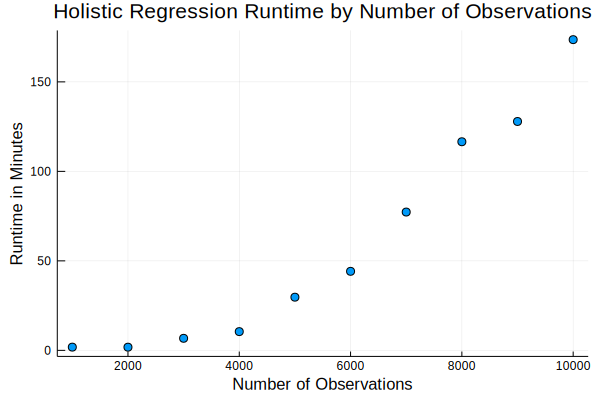

In [40]:
scatter([1*1000:1*1000:10*1000;], obs_run_times/60, title = "Holistic Regression Runtime by Number of Observations", 
xaxis= ("Number of Observations"), yaxis = ("Runtime in Minutes"), 
    legend = :false)

In [41]:
features_run_times = zeros(length(1:1:10),1)
i=1
for k in 1:10
reg = make_regression(1000,5*k)
x= reg[1]
y = reg[2]
features_run_times[i]=@elapsed(HolisticRegression(x, y, 0.99, true, 0.95, true, true, true,false))
i+=1
end

Transformation complete
Upper bound of Objective is 1.9358081126550248
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
M found: 0.35709674630316507
Significance Calculated
Split completed
HCArray found
Academic license - for non-commercial use only
MCArray found, Size: 5
Any[[2, 12], [4, 14], [1, 11, 14, 16], [1, 4, 11, 12, 16], [1, 2, 3, 4, 5, 9, 11, 13, 16, 17, 18, 19]]
Optimizer Starting


┌ Warning: Not solved to optimality, status: Infeasible
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/solvers.jl:212
┌ Warning: Infeasibility ray (Farkas proof) not available
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/solvers.jl:223
┌ Warning: Not solved to optimality, status: Infeasible
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/solvers.jl:212
┌ Warning: Infeasibility ray (Farkas proof) not available
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/solvers.jl:223
┌ Warning: Variable value not defined for component of z. Check that the model was properly solved.
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/JuMP.jl:480


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

┌ Warning: Not solved to optimality, status: Infeasible
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/solvers.jl:212
┌ Warning: Infeasibility ray (Farkas proof) not available
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/solvers.jl:223
┌ Warning: Not solved to optimality, status: Infeasible
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/solvers.jl:212
┌ Warning: Infeasibility ray (Farkas proof) not available
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/solvers.jl:223
┌ Warning: Variable value not defined for component of z. Check that the model was properly solved.
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/JuMP.jl:480


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

┌ Warning: Not solved to optimality, status: Infeasible
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/solvers.jl:212
┌ Warning: Infeasibility ray (Farkas proof) not available
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/solvers.jl:223


MCArray found, Size: 111


Any[[4, 34], [9, 39], [7, 37, 52], [6, 36, 51], [11, 41, 56], [12, 42, 57], [7, 15, 45, 60], [15, 22, 37, 45, 60], [5, 7, 8, 10, 25, 35, 40, 50, 55], [5, 10, 15, 25, 34, 35, 40, 45, 50, 55, 60], [7, 34, 37, 39], [7, 10, 15, 37, 40, 55], [12, 15, 34, 45], [5, 8, 10, 22, 25, 34, 35, 36, 37, 40, 50, 55], [4, 5, 10, 15, 37, 40, 45, 55, 60], [4, 5, 6, 8, 10, 12, 22, 25, 35, 37, 40, 49, 50, 51, 53, 55], [4, 5, 6, 8, 10, 14, 22, 25, 35, 37, 38, 40, 49, 50, 51, 53, 55], [5, 10, 12, 15, 25, 35, 37, 40, 45, 50, 55, 60], [4, 5, 8, 10, 11, 12, 15, 22, 25, 35, 36, 37, 38, 40, 41, 49, 50, 53, 55], [5, 7, 10, 12, 25, 35, 40, 50, 55, 57], [1, 4, 5, 6, 8, 10, 12, 15, 25, 35, 36, 38, 40, 42, 45, 49, 50, 53, 55, 60], [4, 5, 6, 8, 10, 11, 22, 25, 35, 37, 38, 40, 41, 49, 50, 51, 53, 55], [1, 4, 5, 8, 10, 11, 15, 20, 22, 25, 35, 36, 37, 38, 40, 41, 44, 49, 50, 53, 55], [1, 4, 5, 8, 9, 10, 15, 20, 25, 30, 35, 36, 38, 40, 41, 45, 49, 50, 53, 55, 60], [5, 10, 11, 15, 37, 40, 45, 55, 60], [1, 4, 5, 8, 10, 12, 1

┌ Warning: Not solved to optimality, status: Infeasible
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/solvers.jl:212
┌ Warning: Infeasibility ray (Farkas proof) not available
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/solvers.jl:223
┌ Warning: Variable value not defined for component of z. Check that the model was properly solved.
└ @ JuMP /Users/iai/builds/InterpretableAI/SysImgBuilder/.julia/packages/JuMP/I7whV/src/JuMP.jl:480


Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
In sample R^2

InterruptException: InterruptException:

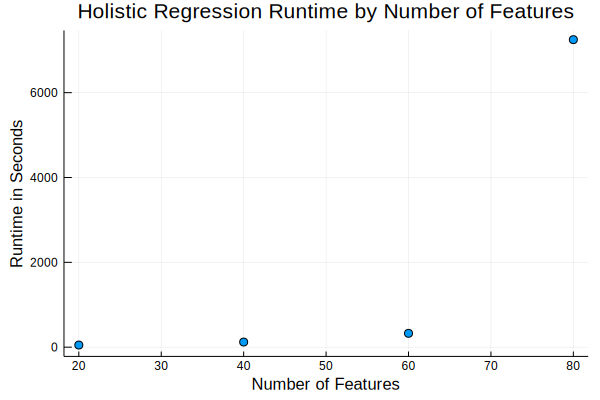

In [57]:
scatter([20:20:80;], features_run_times, title = "Holistic Regression Runtime by Number of Features", 
xaxis= ("Number of Features"), yaxis = ("Runtime in Seconds"), 
    legend = :false)

# Below is L1 Norm for Testing Against

In [509]:
function L1Norm(x,y,p)
    y= convert(Array, y)
    x = convert(Matrix, x)
    m=size(x)[1]
    n=size(x)[2]
    L1Norm = Model(solver=GurobiSolver(TimeLimit=15, OutputFlag=0))
    # Optimization variables
    @variable(L1Norm, t)
    @variable(L1Norm, B[i=1:n] )
    @variable(L1Norm, h[i=1:n] >=0)
    # Objective
    @objective(L1Norm, Min, t+p*sum(h))
    # Constraints
    @constraint(L1Norm, t .>= (y-x*B)'*(y-x*B))
    @constraint(L1Norm, [i=1:n], h[i] >= B[i])
    @constraint(L1Norm, [i=1:n], h[i] >= -B[i])
    solve(L1Norm)
  return getvalue(B)
end

L1Norm (generic function with 1 method)

In [510]:
result_norm = L1Norm(X_admit,y_admit,0)
y_hat = x*result_norm
RMSE = sqrt(mean(((y_hat).-y).^2))
RMSE

Academic license - for non-commercial use only


0.06795205596095125

# DEPRECATED FUNCTIONS FROM MICHAEL'S OLD CODE

In [22]:
#These two functions used to work together to get MultiCollinear pairs, called in SRegression.
function MultiCor(X,ϵ)
X = convert(Matrix, X)
p=size(X)[2]
V,D=eigs(cor(X))
inds=findall(V.<ϵ/p)
MCArray=Array{Int64}(undef,p)
MCArray.=0
    
for ind in inds
        
     vec=abs.(D[ind[1],ind[2]])
     
    vec=abs.(D[:,ind])
        println(vec)
    #vec[filter(vec -> vec.<min(p*ϵ,0.1))]=0
    vec=Array{Int64}(sign.(vec))
    MCArray=vcat(MCArray,vec')
end
if size(MCArray)[1]>1
    zeroes=Array{Int64}(zeros(p))
    for i=1:size(MCArray)[1]
        zeroes=zeroes .| MCArray[i,:]
    end
    MCArray=VecFind(zeroes,D[:,inds])
   MCArray = zeros(0,0)
end
return MCArray
end



function VecFind(ZeroES, ZeroEV)
M=10
if sum(ZeroES)<3
    return ZeroES'
else
indsum=findall(ZeroES.>0.1)
n=size(ZeroEV)[1]
p=size(ZeroEV)[2]
notindsum=filter!(e->!(e in indsum),Vector(1:n))
model=Model(solver=GurobiSolver(OutputFlag=0))
@variable(model,z[1:n],Bin)
@variable(model,β[1:p])
@variable(model,k[1:p])
@variable(model,m[1:p],Bin)
@variable(model,x[1:n])
@variable(model,y[1:n])
@constraint(model,sum(k[i] for i=1:p)==1)
@constraint(model,[i=1:n],x[i]==(ZeroEV*β)[i])
@constraint(model,[i=1:n],y[i]>=x[i])
@constraint(model,[i=1:n],y[i]>=-x[i])
@constraint(model,[i=1:p],k[i]>=β[i])
@constraint(model,[i=1:p],k[i]>=-β[i])
@constraint(model,[i=1:p],k[i]<=-β[i]+2*m[i])
@constraint(model,[i=1:p],k[i]<=β[i]+2*(1-m[i]))
@constraint(model,[i=indsum],y[i]-0.01/sqrt(n)-z[i]*M>=-M)
@constraint(model,[i=indsum],y[i]-0.01/sqrt(n)-z[i]*M<=0)
@constraint(model,[i=notindsum],y[i]-0.001*sqrt(n)-z[i]*M<=0)
@constraint(model,[i=notindsum],y[i]-0.001*sqrt(n)-z[i]*M>=-M)
@constraint(model,[i=1:n],z[i]<=ZeroES[i])
@objective(model,Min,sum(z[i] for i=indsum))
solve(model)
z_opti=round(Int,getvalue(z))
if sum(ZeroES-z_opti)>3 && sum(z_opti)>0
    z_opti_else=VecFind(Array{Int64}(ZeroES-z_opti),ZeroEV)
    return vcat(z_opti',z_opti_else)
elseif sum(ZeroES-z_opti)==3 && sum(z_opti)>0
    return vcat(z_opti',(ZeroES-z_opti)')
elseif sum(z_opti)>0
    return z_opti'
else
    return ZeroES'
end
end
end

VecFind (generic function with 1 method)

In [23]:
# THIS WAS THE OLD SRegression. Many things wrong with it so deprecated it.
# function SRegression(X,Y,HC,NLtrue,sign,Signtrue,Normtrue,MCtrue)
#     #This gets done in the outerfunction
# #     X=convert(Matrix{Float64},X)
# #     Y=convert(Vector{Float64},Y)
#     train=round(Int,size(X)[1]*0.6)
#     test=round(Int,size(X)[1]*0.8)
#     if Normtrue
#         scalerX = StandardScaler()
#         scalerY=StandardScaler()
#         X[1:train,:]=ScikitLearn.fit_transform!(scalerX,X[1:train,:])
#         X[train+1:end,:]=ScikitLearn.transform(scalerX,X[train+1:end,:])
#         Y[1:train,:]=ScikitLearn.fit_transform!(scalerY,Y[1:train,:])
#         Y[train+1:end,:]=ScikitLearn.transform(scalerY,Y[train+1:end,:])
#     end
#     println("Transformation complete")
#     X_train_1=X[1:train,:]
#     Y_train_1=Y[1:train]
#     M=findM(X_train_1,Y_train_1)
#     println("M found: $M")
#     invX=inv(X_train_1'X_train_1)
#     P=X_train_1*(invX)X_train_1'
#     n=size(X_train_1)[1]
#     p=size(X_train_1)[2]
#     #RSS=Y_train_1'*(eye(n)-P)Y_train_1 #EYE NOT DEFINED
#     RSS=Y_train_1'*(I(n)-P)Y_train_1
#     vari=RSS/(n-p)
#     println("Significance Calculated")
#     if NLtrue
#         NLArray, X=NLTransform(X)
#     else
#         NLArray = zeros(0,0)
#     end
#     X_train=X[1:train,:]
#     Y_train=Y[1:train]
#     X_valid=X[train+1:test,:]
#     Y_valid=Y[train+1:test]
#     X_test=X[test:end,:]
#     Y_test=Y[test:end]
#     println("Split completed")
#     HCArray=HighCorrelation(X_train,HC)
#     println("HCArray found")
#     MCArray=MultiCor(X_train,0.01)
#     MCArray = zeros(0,0)
#     MCArraySize=size(MCArray)[1]
#     println("MCArray found, Size: $MCArraySize")
#     β, obj_valid,obj_test, Γ, k=OptimRegression(X_train,Y_train,X_valid,Y_valid,X_test,Y_test,invX,vari,HCArray,HC,M,NLArray,sign,MCArray,NLtrue,Signtrue,false,MCtrue)
#     return β, obj_valid,obj_test, Γ, k
# end

# IGNORE BELOW IT'S EXTRA THAT CAME WITH IT

In [ ]:
function BRegression(X,Y,nsample,HC,sign)
X=convert(Matrix,X)
Y=convert(Vector,Y)
M=findM(X,Y)
println("M found: $M")
function BRegressionWrapper(x)
    β,obj_valid=BootstrapSign(X,Y,nsample,x[1],x[2],HC,sign,M)
    return obj_valid
end
initial_x=[0.1,5]
println("Optimizer Starting")
res=Optim.optimize(BRegressionWrapper, initial_x, NelderMead(),Optim.Options(f_calls_limit=20))
opti_HP=Optim.minimizer(res)
obj_valid=Optim.minimum(res)
β_opti,obj_valid=BootstrapSign(X,Y,nsample,opti_HP[1],opti_HP[2],HC,sign,M)
β_opti[find(abs(β_opti).<1e-5)]=0
test=round(Int,size(X)[1]*0.8)
X_test=X[test+1:end,:]
Y_test=Y[test+1:end]
obj_test=Base.LinAlg.norm(Y_test-X_test*β_opti,2)
return β_opti,obj_valid,obj_test,opti_HP[1],opti_HP[2]
end

In [ ]:
function BootstrapSign(X,Y,nsample,Γ,k,HC,sign,M)
if Γ<=0
    Γ=0
end
if Γ>=1
    Γ=1
end
if k>=size(X)[2]
    k=size(X)[2]
end
if k<=1
    k=1
end
println("Current Gamma is $Γ, k is $k")
train=round(Int,size(X)[1]*0.6)
test=round(Int,size(X)[1]*0.8)
X_train_1=X[1:train,:]
Y_train_1=Y[1:train]
println(size(X_train_1))
invX=inv(X_train_1'X_train_1)
P=X_train_1*(invX)X_train_1'
n=size(X_train_1)[1]
p=size(X_train_1)[2]
RSS=Y_train_1'*(eye(n)-P)Y_train_1
vari=RSS/(n-p)
X_train=X[1:train,:]
Y_train=Y[1:train]
X_valid=X[train+1:test,:]
Y_valid=Y[train+1:test]
X_test=X[test+1:end,:]
Y_test=Y[test+1:end]
HCArray=HighCorrelation(X_train,HC)
βArray=Array{Float64}(0,p)
SGArray=Array{Int64}(0,p)
notsign=1
indicator=1
while notsign>0
    println("This is Bootstrap iteration number $indicator")
    i=0
    β_true,z_true=BootstrapRegressionCareful(X_train,Y_train,Γ,k,HCArray,M,SGArray)
	println("The true beta is $β_true")
    nonzero_β=find(abs(β_true).>=1e-5)
	println("The nonzero beta values are $nonzero_β")
    while i<nsample
    included=rand(1:n,n,1)
    included=convert(Vector,included[:,1])
	X_train_resample=X_train[included,:]
    Y_train_resample=Y_train[included,:]
    β,z_unused=BootstrapRegression(X_train_resample,Y_train_resample,Γ,k,HCArray,M,SGArray)
    βArray=vcat(βArray,β')
    i=i+1
    end
    notsign=0
    for i=1:p
        lb=percentile(βArray[:,i][!isnan(βArray[:,i])],sign*100/2)
        ub=percentile(βArray[:,i][!isnan(βArray[:,i])],100-sign*100/2)
        println("The confidence interval is [$lb,$ub]")
        if lb<0 && ub>0 && (i in nonzero_β)
            notsign=1
        end
    end
    if notsign==1 && p-size(nonzero_β)[1]>0
        append!(nonzero_β,zeros(Int64,(p-size(nonzero_β)[1],1)))
        SGArray=vcat(SGArray,nonzero_β')
	elseif notsign==1
	    SGArray=vcat(SGArray,nonzero_β')
    end
    indicator=indicator+1
end
β_true,z_unused=BootstrapRegressionCareful(X_train,Y_train,Γ,k,HCArray,M,SGArray)
β_true[find(abs(β_true).<1e-5)]=0
obj_valid=Base.LinAlg.norm(Y_valid-X_valid*β_true,2)
return β_true, obj_valid
end

In [ ]:
function BootstrapRegressionCareful(X,Y,Γ,k,HCArray,M,SGArray)
    model=Model(solver=GurobiSolver(OutputFlag=0,NumericFocus=3))
    if size(X)[1] !=size(Y)[1]
        throw(ArgumentError("check sizes of array X and Y"))
    end
    n=size(X)[1]
    p=size(X)[2]
    @variable(model,z[1:p],Bin)
    @variable(model,β[1:p])
    @variable(model,l[1:p])
    @constraint(model,[i=1:p], l[i]>=β[i])
    @constraint(model,[i=1:p], l[i]>=-β[i])
    @constraint(model,[i=1:p], M*z[i]>=β[i])
    @constraint(model,[i=1:p], M*z[i]>=-β[i])
    @constraint(model,sum(z[i] for i=1:p)<=k) #Sparsity
    if size(HCArray)[1]>0
        for i=1:size(HCArray)[1]
            @constraint(model,sum(z[HCArray[i,j]] for j=1:size(HCArray)[2])<=1) #pairwise collinearity
        end
    end
	sizeSG=size(SGArray)[1]
    if size(SGArray)[1]>0
        for i=1:size(SGArray)[1]
            @constraint(model,sum(z[SGArray[i,j]] for j=1:size(SGArray)[2] if SGArray[i,j]>0)<=sum(1 for j=1:size(SGArray)[2] if SGArray[i,j]>0)-1)
        end
    end
    @objective(model, Min, sum((Y[i]-(X*β)[i])*(Y[i]-(X*β)[i]) for i=1:n)/2+sum(l[i] for i=1:p)Γ)
    solve(model)
    β_opti=getvalue(β)
	z_opti=getvalue(z)
	return β_opti, z_opti
end

In [ ]:
function BootstrapRegression(X,Y,Γ,k,HCArray,M,SGArray)
    model=Model(solver=GurobiSolver(OutputFlag=0))
    if size(X)[1] !=size(Y)[1]
        throw(ArgumentError("check sizes of array X and Y"))
    end
    n=size(X)[1]
    p=size(X)[2]
    @variable(model,z[1:p],Bin)
    @variable(model,β[1:p])
    @variable(model,l[1:p])
    @constraint(model,[i=1:p], l[i]>=β[i])
    @constraint(model,[i=1:p], l[i]>=-β[i])
    @constraint(model,[i=1:p], M*z[i]>=β[i])
    @constraint(model,[i=1:p], M*z[i]>=-β[i])
    @constraint(model,sum(z[i] for i=1:p)<=k) #Sparsity
    if size(HCArray)[1]>0
        for i=1:size(HCArray)[1]
            @constraint(model,sum(z[HCArray[i,j]] for j=1:size(HCArray)[2])<=1) #pairwise collinearity
        end
    end
	sizeSG=size(SGArray)[1]
    if size(SGArray)[1]>0
        for i=1:size(SGArray)[1]
            @constraint(model,sum(z[SGArray[i,j]] for j=1:size(SGArray)[2] if SGArray[i,j]>0)<=sum(1 for j=1:size(SGArray)[2] if SGArray[i,j]>0)-1)
        end
    end
    @objective(model, Min, sum((Y[i]-(X*β)[i])*(Y[i]-(X*β)[i]) for i=1:n)/2+sum(l[i] for i=1:p)Γ)
    solve(model)
    β_opti=getvalue(β)
	z_opti=getvalue(z)
	return β_opti, z_opti
end

In [ ]:
function predict_logit(X, β)
  [1.0 / (1.0 + e ^ -(dot(X[i, :], β))) for i = 1:size(X, 1)]
end

In [ ]:
function logistic_regression(X, y,invX,invXT,sign)
  M=1000
  n, p = size(X)
  # Convert y to (-1, +1)
  @assert(extrema(y) == (0, 1), "y must be all 0s and 1s")
  Y = y * 2 - 1
  @assert(extrema(Y) == (-1, 1))

  # Create the model and specify nonlinear solver
  # print_level=0 turns off solver output
  m = Model(solver=PajaritoSolver(mip_solver=GurobiSolver(),cont_solver=IpoptSolver()))
  k=quantile(Chi(1),1-sign)
  # Add variables
  @variable(m, β[1:p])
  @variable(m, z[1:p],Bin)
  @constraint(m,[i=1:p], M*z[i]>=β[i])
  @constraint(m,[i=1:p], M*z[i]>=-β[i])
  @NLconstraint(m,[i=1:p],β[i]^2/sum(invX[i,j]*((1+exp(-sum(X[j,k]*β[k]for k = 1:p)))^2)/exp(-sum(X[j,k]*β[k] for k = 1:p))*invXT[j,i] for j=1:n)>=k*z[i])
  print(m)
  sleep(30)
  # Set nonlinear objective function with @NLobjective
  @NLobjective(m, Max, -sum(
    log(1 + exp(-Y[i] * (sum(X[i, j] * β[j] for j = 1:p))))
    for i = 1:n))

  # Solve the model and get the optimal solutions
  solve(m)
  return getvalue(β)
end

function labelpred(pred, threshold)
    Int.(pred .> threshold)
end

In [ ]:
function logistic_regressor(X,Y,sign)
    X=convert(Matrix{Float64},X)
    Y=convert(Vector,Y)
    train=round(Int,size(X)[1]*0.6)
    test=round(Int,size(X)[1]*0.8)
    scalerX = StandardScaler()
    X[1:train,:]=ScikitLearn.fit_transform!(scalerX,X[1:train,:])
    X[train+1:end,:]=ScikitLearn.transform(scalerX,X[train+1:end,:])
    X=hcat(ones(size(X)[1]),X)
    X_train=X[1:train,:]
    Y_train=Y[1:train]
    X_valid=X[train+1:test,:]
    Y_valid=Y[train+1:test]
    X_test=X[test:end,:]
    Y_test=Y[test:end]
    invX=pinv(X_train)
    invXT=pinv(X_train')
    β= logistic_regression(X_train, Y_train,invX,invXT,sign)
    β[find(abs(β).<1e-5)]=0
    pred=predict_logit(X_valid,β)
    function logisticwrapper(threshold)
        label=labelpred(pred,threshold)
        output=mean(label .== Y_valid)
        return output
    end
    optim_model=Optim.optimize(logisticwrapper,0,1)
    thres_opti=Optim.minimizer(optim_model)
    test_loss=mean(labelpred(predict_logit(X_test,β),thres_opti).==Y_test)
    return test_loss, thres_opti, β
end

In [ ]:
function CART_regressor(X,Y)
    X=convert(Matrix,X)
    Y=convert(Array,Y)
    train=round(Int,size(X)[1]*0.6)
    test=round(Int,size(X)[1]*0.8)
    X_train=X[1:test,:]
    Y_train=Y[1:test]
    X_test=X[test+1:end,:]
    Y_test=Y[test+1:end,:]
    tree = GridSearchCV(DecisionTreeRegressor(), Dict(:max_depth => 2:8,:min_samples_leaf => [5,10,20,50]))
    ScikitLearn.fit!(tree,X_train,Y_train)
    M_Dict=tree.best_params_
    tree = DecisionTreeRegressor(min_samples_leaf=M_Dict[:min_samples_leaf], max_depth=M_Dict[:max_depth])
    ScikitLearn.fit!(tree,X_train, Y_train)
    pred=ScikitLearn.predict(tree,X_test)[:,1]
    test_loss=Base.LinAlg.norm(Y_test-pred,2)
    return test_loss
end

In [ ]:
function CART_classifier(X,Y)
    X=convert(Matrix,X)
    Y=convert(Array,Y)
    train=round(Int,size(X)[1]*0.6)
    test=round(Int,size(X)[1]*0.8)
    X_train=X[1:test,:]
    Y_train=Y[1:test]
    X_test=X[test+1:end,:]
    Y_test=Y[test+1:end]
    tree = GridSearchCV(DecisionTreeClassifier(), Dict(:max_depth => 2:8,:min_samples_leaf => [5,10,20,50]))
    ScikitLearn.fit!(tree,X_train,Y_train)
    M_Dict=tree.best_params_
    tree = DecisionTreeClassifier(min_samples_leaf=M_Dict[:min_samples_leaf], max_depth=M_Dict[:max_depth])
    ScikitLearn.fit!(tree,X_train, Y_train)
    label=ScikitLearn.predict(tree,X_test)[:,1]
    accuracy=mean(label.==Y_test)
    return accuracy
end